### <font color='darkblue'>Introduction et Présentation des données  </font>

La segmentation sémantique d'image est une technique qui constitue une première étape nécessaire à l'analyse des images. Celle-ci permet de représenter une image de manière significative et facilement analysable en diviser une image en plusieurs parties/segments ayant des caractéristiques ou des attributs similaires. Elle peut servir dans la vision par ordinateur par exemple, à comprendre une scène à laquelle renvoie une image. 

Dans ce notebook, nous nous intéressons à une base de données d'images captées par un drone (Semantic Drone Dataset). Cette base a été réalisée afin de  comprendre la sémantique des scènes urbaines et pour augmenter la sécurité des procédures de vol et d'atterrissage des drones autonomes. L'imagerie représente plus de 20 maisons en vue nadir (vue d'oiseau) photographiées à une altitude de 5 à 30 mètres au-dessus du sol. Une caméra haute résolution a été utilisée pour obtenir ces images et celles-ci sont de taille de 6000x4000px (24 Mégapixel).La base dont nous disposont comporte 400 images et les pixels sont étiquetés en 23 classes comme suit : 

**unlabeled, paved-area, dirt, grass, gravel, water, rocks, pool, vegetation, roof, wall, window, door, fence, fence-pole, person, dog, car, bicycle, tree, bald-tree, ar-marker, obstacle**

La base de données est disponible sur kaggle à cette <a href="https://www.kaggle.com/awsaf49/semantic-drone-dataset">adresse</a> ou <a href="https://www.kaggle.com/bulentsiyah/semantic-drone-dataset">ici</a>, et a été fournie par Graz University of Technology (http://dronedataset.icg.tugraz.at ; https://www.tugraz.at/index.php?id=22387) 

Notre objectif est d'appliquer les réseaux convolutionnels, notamment le réseau U-net, dans la tâche de la segmantation sémantique.

In [34]:
##importons les packages 

import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

import random


import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

**Odonner les chemins relatifs aux différentes images et masques**

In [4]:
chemin_image = "./archive_drone/semantic_drone_dataset/original_images/"
chemin_mask = "./archive_drone/semantic_drone_dataset/label_images_semantic/"

input_img_paths = sorted(
    [
        os.path.join(chemin_image, fname)
        for fname in os.listdir(chemin_image)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(chemin_mask, fname)
        for fname in os.listdir(chemin_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

In [4]:
images = sorted(os.listdir("./archive_drone/semantic_drone_dataset/original_images/"))
masques = sorted(os.listdir("./archive_drone/semantic_drone_dataset/label_images_semantic/"))

In [5]:
print("images :","\n", input_img_paths[0:3], "\n","\n","masques :","\n",target_img_paths[0:3])

images : 
 ['./archive_drone/semantic_drone_dataset/original_images/000.jpg', './archive_drone/semantic_drone_dataset/original_images/001.jpg', './archive_drone/semantic_drone_dataset/original_images/002.jpg'] 
 
 masques : 
 ['./archive_drone/semantic_drone_dataset/label_images_semantic/000.png', './archive_drone/semantic_drone_dataset/label_images_semantic/001.png', './archive_drone/semantic_drone_dataset/label_images_semantic/002.png']


In [6]:
len(input_img_paths)

400

In [7]:
# size of the image
image1 = PIL.Image.open(input_img_paths[1])
image1 = np.asarray(image1)
a = image1.shape

image2 = PIL.Image.open(target_img_paths[1])
image2 = np.asarray(image2)
b = image2.shape
c = np.unique(image2)
print("image size",a,"\n","masque size",b,"\n", "classes :",c )

image size (4000, 6000, 3) 
 masque size (4000, 6000) 
 classes : [ 0  1  2  3  8  9 10 11 12 13 14 15 19 20 21 22]


Donc les images ont trois channels : RGB, et les masques sont en gris. La taille des images étant très grandes (4000, 6000), nous réduisons leur taille à (272, 400)

In [62]:
os.mkdir('image_red')
os.mkdir('mask_red')

FileExistsError: [WinError 183] Impossible de créer un fichier déjà existant: 'image_red'

In [27]:
for i,image in zip(images,input_img_paths):  #iterate through each file 
        o_img = PIL.Image.open(image)  
        o_img = o_img.resize((400,272))
        o_img.save('./image_red/'+i)

In [57]:
new_input_img_paths = os.listdir('./image_red/')

In [58]:
new_input_img_paths = ['./image_red/'+i for i in new_input_img_paths]

In [30]:
for i,image in zip(masques,target_img_paths):  #iterate through each file 
        o_img = PIL.Image.open(image)  
        o_img = o_img.resize((400,272))
        o_img.save('./mask_red/'+i)

In [60]:
new_target_img_paths = os.listdir('./mask_red/')
new_target_img_paths = ['./mask_red/'+i for i in new_target_img_paths]

In [32]:
##vérifier les différentes classes existantes
w = []
for image in new_target_img_paths:   
    ima = PIL.Image.open(image)
    ima = np.asarray(ima)
    w.append(np.unique(ima).tolist())
w

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [0,
  1,
  2

Lorsque nous vérifions le nombre de classe des pixels apres la réduction, il y a en 26, mais pour quelle raison, on ne sait pas

In [33]:
max( max(x) for x in w   )

25

<font color='darkblue'> **Visualisation**

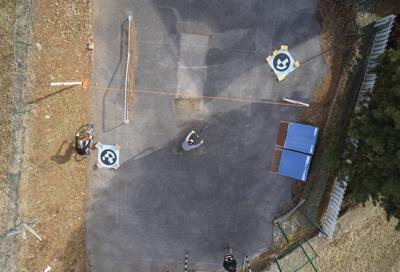

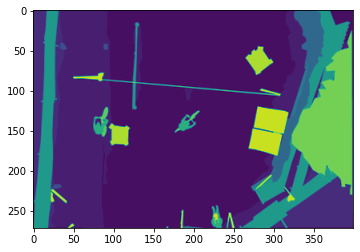

In [61]:
# Display input image
display(Image(filename=new_input_img_paths[10]))
# Display auto-contrast version of corresponding target (per-pixel categories)

v_img1 = PIL.Image.open(new_target_img_paths[10])  
v_img1 = np.asarray(v_img1)
plt.imshow(v_img1)
plt.grid(False)

Construire une classe nommée sequence pour charger et vectoriser des lots de données (mini-batch)

In [17]:
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """classe pour charger les données de façon itérative comme si on avait des tableaux numpy)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Renvoie le tuple (input, target) correspondant au batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32") ## ceci servira à initiailiser la taille des images à (batch_size, 288, 288, 1) 
        for j, path in enumerate(batch_input_img_paths): ## pour chaque image du mini-batch, il faut la convertir en array (il s'agira d'un array 2-D: (288,288))
            img = load_img(path, target_size=self.img_size)            
            x[j] = img
            x[j] =x[j]/255.0 ## normalisation
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8") ## ceci servira à initiailiser la taille des masques à (batch_size, 288, 288, 1)
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

### <font color='darkblue'>Les différents types de réseaux de neurones pour la segmentation sémantique </font>

**Based on Fully Convolutional Network (FCN)** 

**Based on Dialtation/Atrous convolution :** Dialatednet, DeepLab,FC-DenseNet

**Based on Top-down/Bottom-up approach:**  Deconvnet, Seg-Net, U-net

**Based on Global Context :** ParseNet,GCN, EncNet

**Based on receptive field enlargement and multi-scale context incorporation:** PSPNet: Pyramid Scene Parsing Network(PSPNet); Gated-SCNN


U-Net: U-Net  is a U-shaped semantic segmentation network which has a contracting path and an expansive path. Every step of the contracting path consists of two consecutive 3 × 3 convolutions followed by ReLU nonlinearity and max-pooling using 2 × 2 window with stride 2. During the contraction, the feature information is increased while spatial
information is decreased. On the other hand, every step of the expansive path consists of up-sampling of feature map followed by a 2×2 up-convolution. This reduces the feature map size by a factor of 2. Then the reduced feature map is concatenated with the corresponding 240 cropped feature map from the contracting path. Then two consecutive 3 × 3 convolution operations are applied followed by ReLU nonlinearity. In this way, the expansive pathway
combines the features and spatial information for precise segmentation. (Sultana, Sufian et Dutta; 2020)

<img src="unet2.png" style="width:500px;height:300px;">
<caption><center> <u> <font color='purple'> Contracting and expansive architecture of U-Net.</u></center></caption>

### <font color='darkblue'> Construction du réseau U-net avec un style Xception (présence de skip-connections)    

In [18]:
from tensorflow.keras import layers
## nous nous inspirons de : https://keras.io/examples/vision/oxford_pets_image_segmentation/

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 1, activation="softmax", padding="same")(x) ##noter qu'ici à la différence des CNN , cette dernière couche n'est pas une couche fully connected, mais une couche convolutionnelle

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model_unet = get_model(img_size = (272,400), num_classes=26)
model_unet.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 267, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 134, 200, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 134, 200, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 134, 200, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

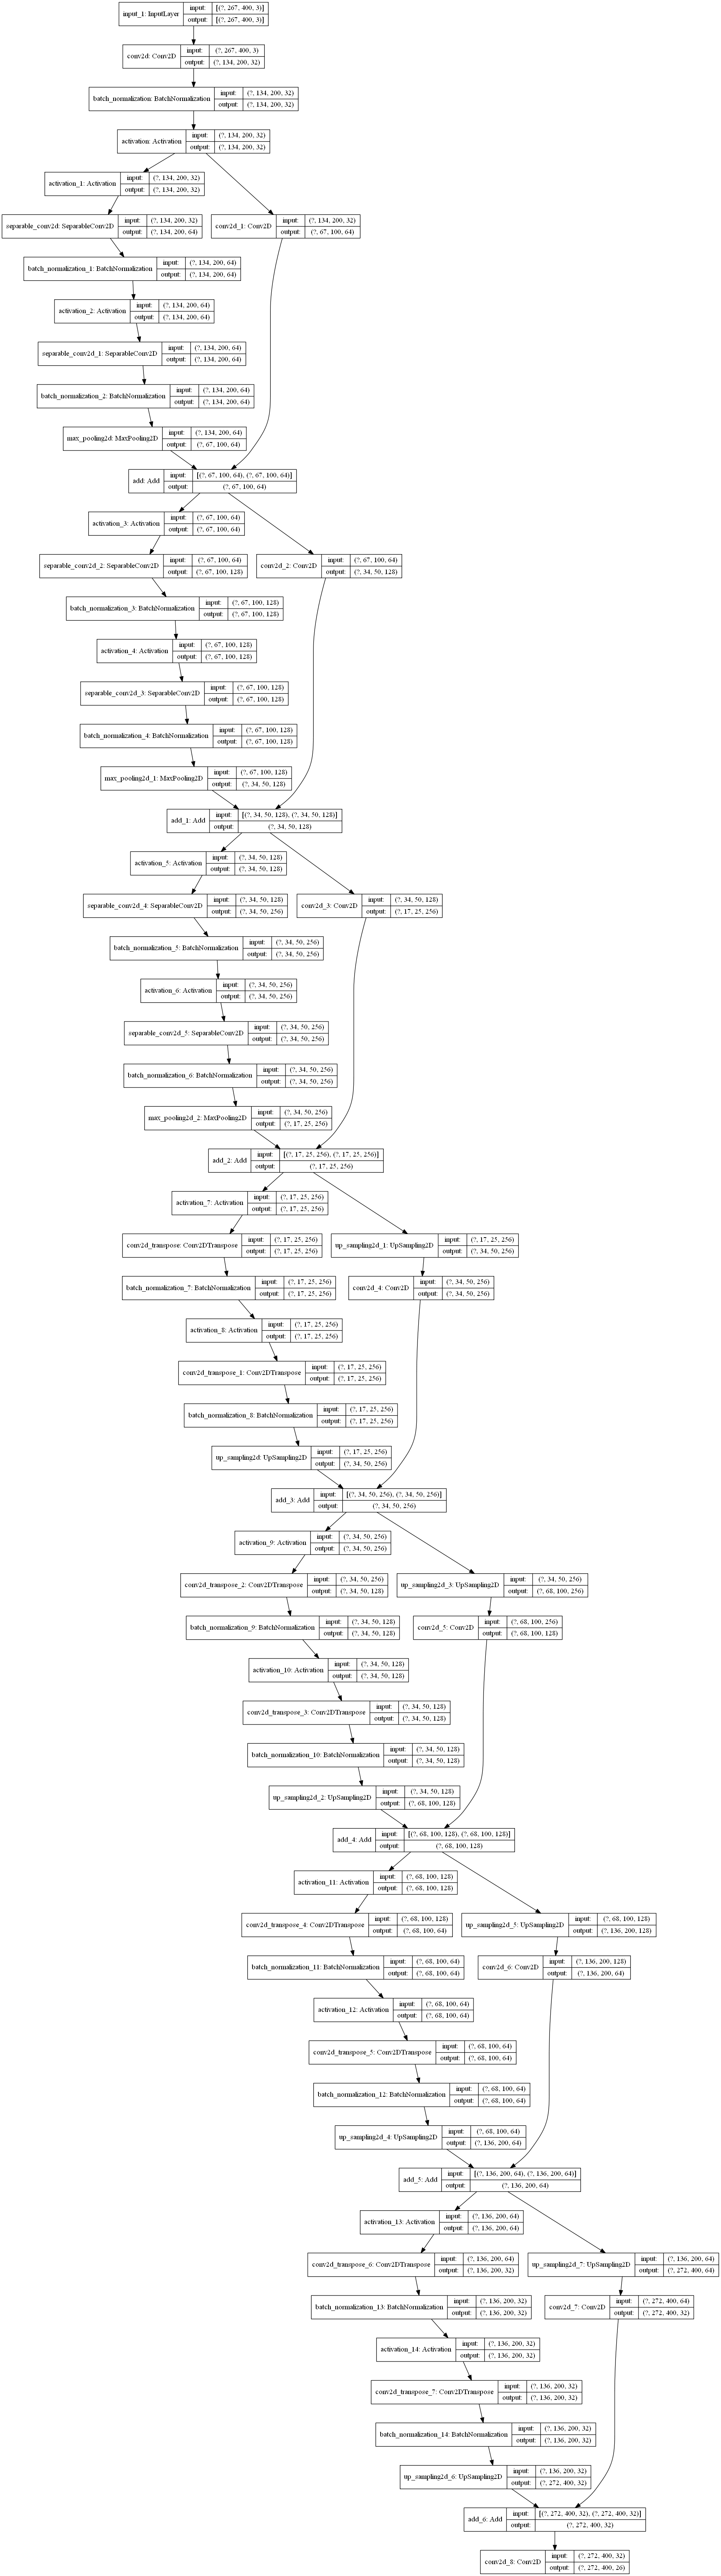

In [19]:
import pydot
keras.utils.plot_model(model_unet, show_shapes=True)

**Nous constituons un échantillon d'apprentissage représentant 70% de nos données, en utilisant nos images et masques de tailles réduites ; le reste servira à l'évaluation et au test. L'échantillon d'évaluation servira à choisir lors du early stopping le modèle avec un bon score pour la métrique qu'on utilisera pour l'évaluation**

echantillon d'apprentissage : 400*70% = 280 images 

In [34]:
from sklearn.model_selection import train_test_split
train_input_img_paths, val_input_img_paths, train_target_img_paths, val_target_img_paths = train_test_split(new_input_img_paths,new_target_img_paths , test_size=0.3, random_state=42)

echantillon d'évaluation : 90 images 

echantillon test: 30 Images 

In [35]:
new_val_input_img_paths = val_input_img_paths[:90]
new_val_target_img_paths = val_target_img_paths[90:]

test_input_img_paths = val_input_img_paths[:90]
test_target_img_paths = val_target_img_paths[:90]

In [36]:
# Instantiate data Sequences for each split

train_gen = OxfordPets(batch_size = 16, img_size = (272,400),input_img_paths =  train_input_img_paths ,
     target_img_paths = train_target_img_paths)

val_gen = OxfordPets(batch_size = 16, img_size = (272,400), input_img_paths = new_val_input_img_paths,
                     target_img_paths = new_val_target_img_paths)
 
test_gen = OxfordPets(batch_size = 16, img_size = (272,400), input_img_paths = test_input_img_paths,
                     target_img_paths = test_target_img_paths)

### <font color='darkblue'> Métrique pour l'evaluation  </font>

<img src="iou1.png" style="width:500px;height:300px;">
<caption><center> <u> <font color='purple'> 

**In terms of confusion matrix, the metrics can be rephrased true/false positive/negative**
    
<img src="iou2.png" style="width:380px;height:100px;">
<caption><center> <u> <font color='purple'> 


### <font color='darkblue'>  Apprentissage

In [63]:
#on contruit une classe pour le calcul de l'IoU
class MaskMeanIoU(tf.keras.metrics.MeanIoU):
    """Mean Intersection over Union """
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight=sample_weight)

**Méthode d'optimisation** : Adam (Adaptive moment estimation)

**learning rate :** 1e-3

**Fonction de perte :** sparse_categorical_crossentropy. Cela nous permet de ne pas avoir à faire une transformation en one hot encoding des masques. Mais avec cette fonction nous n'avons pas pu utiliser directement la métrique `tf.keras.metrics.MeanIoU` c'est la raison pour laquelle on a dû définir une fonction pour le calcul de l'iou )

**Pour eviter l'overfitting** nous utilisons le early stopping, nous prenons 10 comme niveau de patience. Ainsi, si après 10 epoch consécutivement l'IoU n'augmente pas sur  l'échantillon de validation; on arrête l'apprentissage afin d'éviter le sur apprentissage. On aurait pu aussi utiliser le dropout

In [38]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

model_unet.compile(optimizer =Adam(learning_rate=1e-3) , loss="sparse_categorical_crossentropy",
                metrics = ['accuracy', MaskMeanIoU(name='iou', num_classes = 26)])

callbacks = [EarlyStopping(patience=10, verbose=1, monitor='val_iou'),
            ReduceLROnPlateau(factor=0.1,cooldown= 10,patience=10,verbose =1,min_lr=0.1e-6,monitor='val_iou'),
    ModelCheckpoint('drone_segmentation.h5', verbose=1, save_best_only=True, save_weights_only=True, 
                    monitor='val_iou')]

In [39]:
epochs = 15
result_unet = model_unet.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.5885 - accuracy: 2.8249e-05 - iou: 0.1324 
Epoch 00001: val_iou improved from inf to 0.00407, saving model to drone_segmentation.h5
17/17 [==============================] - 336s 20s/step - loss: 1.5885 - accuracy: 2.8249e-05 - iou: 0.1324 - val_loss: 5.6847 - val_accuracy: 0.0000e+00 - val_iou: 0.0041
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.3128 - accuracy: 1.2151e-04 - iou: 0.1478 
Epoch 00002: val_iou did not improve from 0.00407
17/17 [==============================] - 384s 23s/step - loss: 1.3128 - accuracy: 1.2151e-04 - iou: 0.1478 - val_loss: 4.5334 - val_accuracy: 0.0000e+00 - val_iou: 0.0073
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 1.1691 - accuracy: 5.2714e-06 - iou: 0.1704 
Epoch 00003: val_iou did not improve from 0.00407
17/17 [==============================] - 390s 23s/step - loss: 1.1691 - accuracy: 5.2714e-06 - iou: 0.1704 - val_loss: 6.1503 - va

Nous voyons que l'apprentissage a été arrêté , de plus l'IoU est trs faible ; ce qui augure un mauvais résultat. Regardons un exemple sur un exemple test 

### <font color='darkblue'> Test </font>

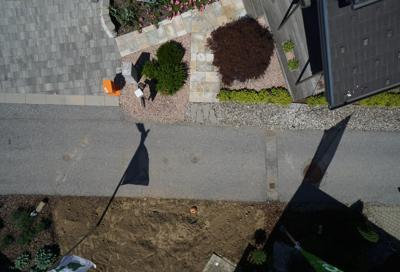

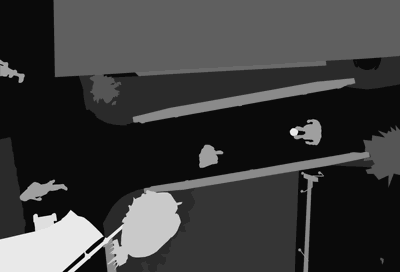

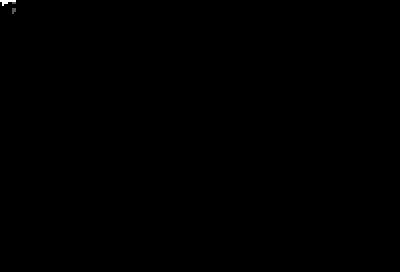

In [41]:
# Generate predictions for all images in the validation set

val_preds = model_unet.predict(test_gen)

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=new_val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(new_val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i) 


In [48]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    return mask

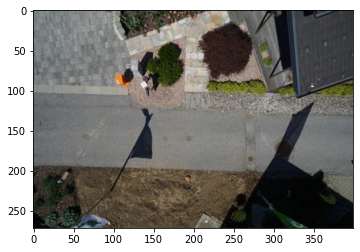

In [43]:
plt.imshow( PIL.Image.open(test_input_img_paths[10]))
plt.grid(False)

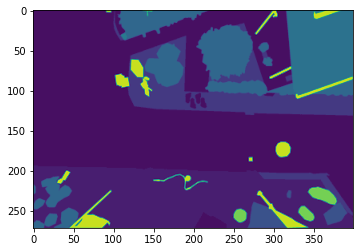

In [46]:
label_image_semantic1 = PIL.Image.open(test_target_img_paths[10])
label_image_semantic1 = np.asarray(label_image_semantic1)
plt.imshow(label_image_semantic1)
plt.grid(False)

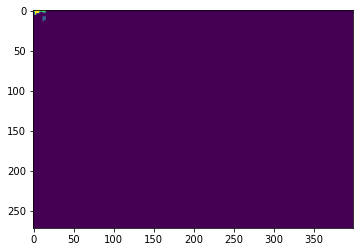

In [49]:
pred = display_mask(i)
plt.imshow(pred)

Notre modèle n'étant pas performant, nous allons utiliser un modèle pré-entrainé 

### <font color='darkblue'>Modèle pré-entrainé </font>

In [2]:
##créer deux dossiers pour stocker les images et masques qui vont servir à l'apprentissage
os.mkdir('image320')
os.mkdir('mask320')

On choisit 80% des images pour entrainer le modèle pré-entrainé, soit 400*0.8 = 320

In [5]:
random.seed(4)
ima = random.sample(input_img_paths,320) ## images qui vont servir pour l'apprentissage
random.seed(4)
mask = random.sample(target_img_paths,320) ## masques qui vont servir pour l'entrainement

In [30]:
## listes des images et masques qui serviront au test
test_input_img_paths = sorted([image for image in filter (lambda x: x not in ima, input_img_paths)]) 

test_target_img_paths = sorted([image for image in filter (lambda x: x not in mask, target_img_paths)])

In [32]:
len(test_target_img_paths)

80

In [6]:
##stockages images train
for i,image in enumerate(ima):  
        o_img = PIL.Image.open(image)  
        o_img.save('./image320/'+str(i)+'.jpg')

In [7]:
for i,image in enumerate(mask):  
        o_img = PIL.Image.open(image)  
        o_img.save('./mask320/'+str(i)+'.png')

In [36]:
##stockage images test
os.mkdir('image_test')
for i,image in enumerate(test_input_img_paths):  
        o_img = PIL.Image.open(image)  
        o_img.save('./image_test/'+str(i)+'.jpg')

In [37]:
##stockages masques test
os.mkdir('mask_test')
for i,image in enumerate(test_target_img_paths):  
        o_img = PIL.Image.open(image)  
        o_img.save('./mask_test/'+str(i)+'.png')

In [8]:
!pip install keras-segmentation

### <font color='darkblue'> Chargement du modèle U-net VGG16 </font>

Nous utilisons directement les images en tailles réelles, le modèle se chargera de réduire lui même la taille à (416, 608)  

In [9]:
from keras_segmentation.models.unet import vgg_unet

n_classes = 23 # Aerial Semantic Segmentation Drone Dataset tree, gras, other vegetation, dirt, gravel, rocks, water, paved area, pool, person, dog, car, bicycle, roof, wall, fence, fence-pole, window, door, obstacle
model = vgg_unet(n_classes=n_classes ,  input_height=416, input_width=608  )

model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 608, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 416, 608, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 416, 608, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 208, 304, 64) 0           block1_conv2[0][0]               
_______________________________________________________________________________________

In [12]:
import timeit

In [13]:
start = timeit.default_timer() # start timer
model.train( 
    train_images = "./image320/" ,
    train_annotations = "./mask320/",
    checkpoints_path = "vgg_unet" , epochs=5 )
stop = timeit.default_timer() # stop timer
print('Time: {:.5f} '.format(stop - start)) ## temps en seconde

Verifying training dataset


100%|██████████| 320/320 [04:11<00:00,  1.27it/s]


Dataset verified! 
Epoch 1/5
512/512 [==============================] - 12821s 25s/step - loss: 3.4360 - accuracy: 0.1196
Epoch 2/5
512/512 [==============================] - 10268s 20s/step - loss: 3.1040 - accuracy: 0.2575
Epoch 3/5
512/512 [==============================] - 11150s 22s/step - loss: 2.8740 - accuracy: 0.3112
Epoch 4/5
512/512 [==============================] - 11007s 21s/step - loss: 2.7113 - accuracy: 0.3522
Epoch 5/5
512/512 [==============================] - 9649s 19s/step - loss: 2.5878 - accuracy: 0.3901
Time: 55284.21969 


L'apprentissage prend énormément de temps 55284,21969 s soit environ 15,35 heures !

### <font color='darkblue'> Evaluation du model </font>

In [39]:
start = timeit.default_timer() # start timer
# evaluating the model on the test set

print(model.evaluate_segmentation( inp_images_dir= './image_test/', annotations_dir= './mask_test/' ))

stop = timeit.default_timer() # stop timer
print('Time: {:.5f} s'.format(stop - start)) ## temps en seconde

80it [04:31,  3.40s/it]

{'frequency_weighted_IU': 0.2643773062469646, 'mean_IU': 0.058392554433781156, 'class_wise_IU': array([3.29813106e-03, 5.36269503e-01, 2.95761254e-02, 2.20328794e-01,
       1.71015801e-01, 1.14624809e-02, 8.76573833e-03, 3.03988117e-03,
       2.17640932e-01, 2.65567717e-02, 1.80731809e-02, 5.37750247e-03,
       9.84096993e-05, 1.12264769e-02, 1.44755400e-03, 1.21230704e-02,
       6.38162093e-04, 1.92057415e-03, 3.02252401e-03, 1.52518120e-02,
       2.14217010e-02, 9.97563204e-04, 2.34760633e-02])}
Time: 271.79484 s


On peut y voir l'IOU par classe, mais c'est toujours faible

In [48]:
os.mkdir('image_pred')

In [44]:
test_input_img_paths

['./archive_drone/semantic_drone_dataset/original_images/001.jpg',
 './archive_drone/semantic_drone_dataset/original_images/005.jpg',
 './archive_drone/semantic_drone_dataset/original_images/008.jpg',
 './archive_drone/semantic_drone_dataset/original_images/022.jpg',
 './archive_drone/semantic_drone_dataset/original_images/023.jpg',
 './archive_drone/semantic_drone_dataset/original_images/041.jpg',
 './archive_drone/semantic_drone_dataset/original_images/044.jpg',
 './archive_drone/semantic_drone_dataset/original_images/058.jpg',
 './archive_drone/semantic_drone_dataset/original_images/078.jpg',
 './archive_drone/semantic_drone_dataset/original_images/089.jpg',
 './archive_drone/semantic_drone_dataset/original_images/098.jpg',
 './archive_drone/semantic_drone_dataset/original_images/106.jpg',
 './archive_drone/semantic_drone_dataset/original_images/110.jpg',
 './archive_drone/semantic_drone_dataset/original_images/112.jpg',
 './archive_drone/semantic_drone_dataset/original_images/113.j

In [46]:
start = timeit.default_timer() # start timer


out = model.predict_segmentation(inp=test_input_img_paths[1],
                                 out_fname = "./image_pred/out1.png")

stop = timeit.default_timer() # stop timer
print('Time: {:.5f} s'.format(stop - start)) ## temps en seconde

Time: 4.03457 s


### <font color='darkblue'> Test </font>

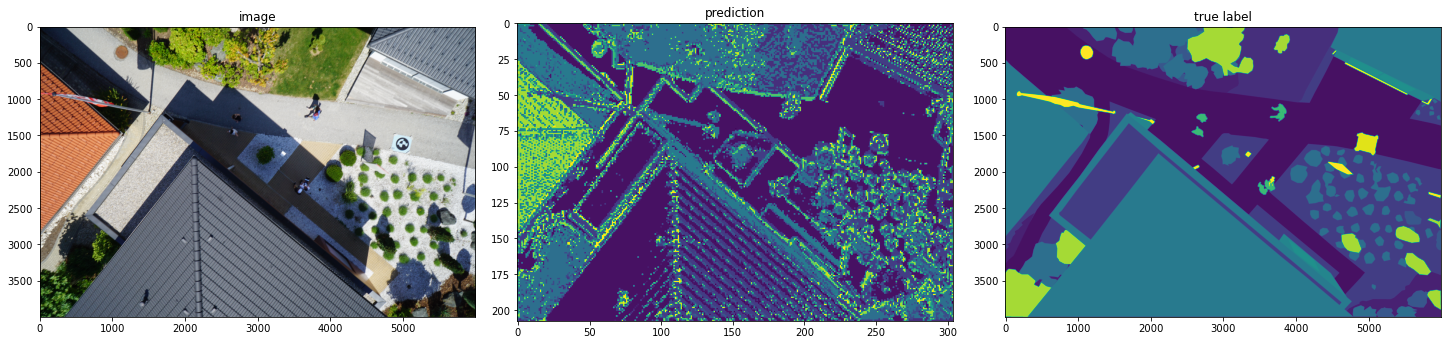

In [53]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20), constrained_layout=True)

img_orig = PIL.Image.open(test_input_img_paths[1])
axs[0].imshow(img_orig)
axs[0].set_title('image')
axs[0].grid(False)

axs[1].imshow(out)
axs[1].set_title('prediction')
axs[1].grid(False)

axs[2].imshow(PIL.Image.open(test_target_img_paths[1]))
axs[2].set_title('true label')
axs[2].grid(False)

Quoique, le  résultat est meilleur que celui de notre propre modèle, mais le modèle confond beaucoup de classe, certains pixels coloriés en jaune normalement, sont en vert et vice-versa.  

Time: 4.15397 s


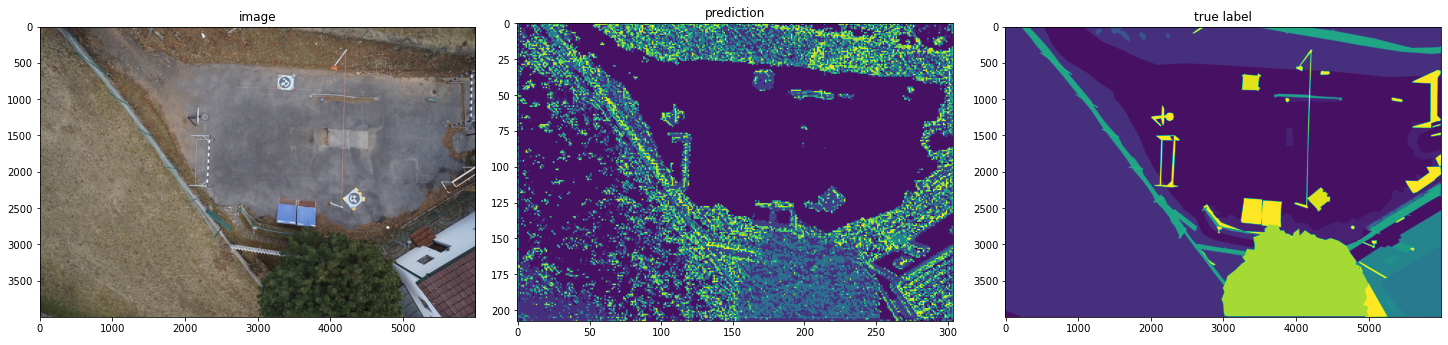

In [55]:
start = timeit.default_timer() # start timer

out2 = model.predict_segmentation(inp=test_input_img_paths[50], out_fname = "./image_pred/out2.png")

stop = timeit.default_timer() # stop timer
print('Time: {:.5f} s'.format(stop - start)) ## temps en seconde

fig, axs = plt.subplots(1, 3, figsize=(20, 20), constrained_layout=True)

img_orig = PIL.Image.open(test_input_img_paths[50])
axs[0].imshow(img_orig)
axs[0].set_title('image')
axs[0].grid(False)

axs[1].imshow(out2)
axs[1].set_title('prediction')
axs[1].grid(False)

axs[2].imshow(PIL.Image.open(test_target_img_paths[50]))
axs[2].set_title('true label')
axs[2].grid(False)

Même constat que précédemment

### <font color='darkblue'> Conclusion </font>
En conclusion, les performances des deux modèles que nous avons utilisés ne sont pas bonnes, mais celles du modèle pré entrainé sont mieux. Pour améliorer ce travail, il faudra prendre plus de temps pour mieux chercher des hyperparamètres (hyperparameter tuning) qui sont plus adaptés à notre base de données.

### <font color='darkblue'> Bibliographie</font>
- Farhana Sultana, Abu Sufian, Paramartha Dutta (2020). Evolution of image segmentation using deep convolutional neural
  network: A survey. DOI: https://doi.org/10.1016/j.knosys.2020.106062  
  

- Hongshan Yu, Zhengeng Yang, Lei Tan , Yaonan Wang, Wei Sun, Mingui Sun, Yandong Tang (2018). Methods and datasets on semantic segmentation: A review


- Bianca-Cerasela-Zelia Blaga, Sergiu Nedevschi (2019). Semantic Segmentation Learning for Autonomous UAVs using Simulators and Real Data?https://www.researchgate.net/publication/335714815_Semantic_Segmentation_Learning_for_Autonomous_UAVs_using_Simulators_and_Real_Data


- https://keras.io/examples/vision/oxford_pets_image_segmentation/


- https://github.com/divamgupta/image-segmentation-keras


- https://github.com/toebsen/ml/blob/master/Semantic_Segmentation.ipynb
